In [ ]:
!pip install mlflow boto3 awscli

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 123.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 133.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.0/677.0 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
!aws configure

In [ ]:
import mlflow
mlflow.set_tracking_uri('http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/')
mlflow.set_experiment('Experiment-2 BoW vs TFIDF')

2025/07/26 10:25:39 INFO mlflow.tracking.fluent: Experiment with name 'Experiment-2 BoW vs TFIDF' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlflow-bucket-26072025/540251406138198295', creation_time=1753525539492, experiment_id='540251406138198295', last_update_time=1753525539492, lifecycle_stage='active', name='Experiment-2 BoW vs TFIDF', tags={}>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow.sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix


In [ ]:
df=pd.read_csv('/content/reddit_preprocessing.csv').dropna(subset=['clean_comment'])
df.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


In [ ]:
def run_experiment(vectorizer_type,ngram_range,vectorizer_max_features,vectorizer_name):
  if vectorizer_type=="BoW":
    vectorizer=CountVectorizer(ngram_range=ngram_range,max_features=vectorizer_max_features)
  else:
    vectorizer=TfidfVectorizer(ngram_range=ngram_range,max_features=vectorizer_max_features)

  X_train,X_test,y_train,y_test=train_test_split(df['clean_comment'],df['category'],test_size=0.2,random_state=42)
  X_train_vectorized=vectorizer.fit_transform(X_train)
  X_test_vectorized=vectorizer.transform(X_test)

  with mlflow.start_run():
    mlflow.set_tag("mlflow.Name",f"{vectorizer_name}_{ngram_range}_RandomForest")
    mlflow.set_tag("experiment_type","featureEngineering")
    mlflow.set_tag("model_type","RandomForestClassifier")
    mlflow.set_tag("description",f"RandomForest with {vectorizer_name},n_gram={ngram_range} and max_features={vectorizer_max_features}")

    mlflow.log_params({
        "vectorizer_type":vectorizer_type,
        "ngram_range":ngram_range,
        "vectorizer_max_features":vectorizer_max_features
    })

    n_estimators=200
    max_depth=15

    mlflow.log_params({
        "n_estimators":n_estimators,
        "max_depth":max_depth
    })

    model=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth)
    model.fit(X_train_vectorized,y_train)
    y_pred=model.predict(X_test_vectorized)

    accuracy=accuracy_score(y_test,y_pred)
    mlflow.log_metric("accuracy",accuracy)

    classification_rep=classification_report(y_test,y_pred,output_dict=True)
    for label,metrics in classification_rep.items():
      if isinstance(metrics,dict):
        for metric,value in metrics.items():
          mlflow.log_metric(f"{label}_{metric}",value)

    confusion_mat=confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_mat,annot=True,fmt='d',cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    mlflow.log_artifact('confusion_matrix.png')


    mlflow.sklearn.log_model(model,f"random_forest_model_{vectorizer_name}_{ngram_range}")

In [ ]:
n_gram_range=[(1,1),(1,2),(1,3)]
max_features=5000

2025/07/26 11:01:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/26 11:02:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run hilarious-cat-367 at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/540251406138198295/runs/f8fff610e8e44cabbb3458c835888cfb
🧪 View experiment at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/540251406138198295


2025/07/26 11:02:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/26 11:02:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run shivering-vole-60 at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/540251406138198295/runs/4e54dd293ac24f50bf1768bb30de76e0
🧪 View experiment at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/540251406138198295


2025/07/26 11:02:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/26 11:02:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run chill-goose-402 at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/540251406138198295/runs/f72c9992df174a339bd4697bdb0c894f
🧪 View experiment at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/540251406138198295


2025/07/26 11:03:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/26 11:03:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run adventurous-bird-764 at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/540251406138198295/runs/f192af7ba87f42ce998a9ddcbf66d4ee
🧪 View experiment at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/540251406138198295


2025/07/26 11:03:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/26 11:03:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run magnificent-conch-47 at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/540251406138198295/runs/017ff08454304c1a8b79a04bd2576731
🧪 View experiment at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/540251406138198295


2025/07/26 11:04:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/26 11:04:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run learned-jay-874 at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/540251406138198295/runs/529c18ced336458288941718119fd2c6
🧪 View experiment at: http://ec2-13-234-122-130.ap-south-1.compute.amazonaws.com:5000/#/experiments/540251406138198295


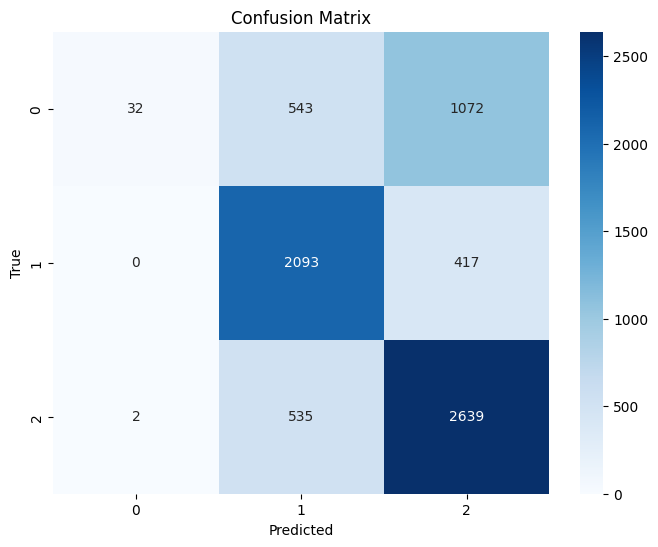

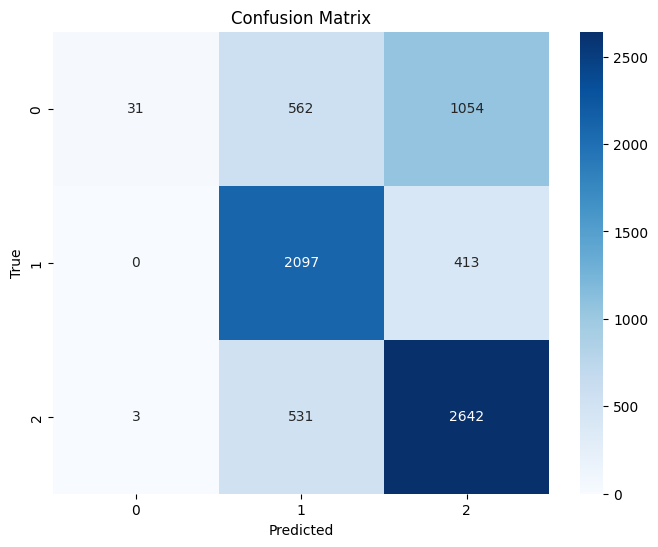

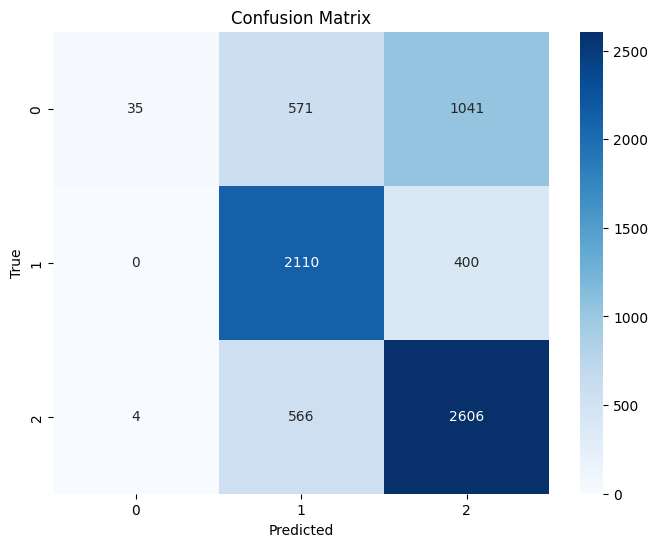

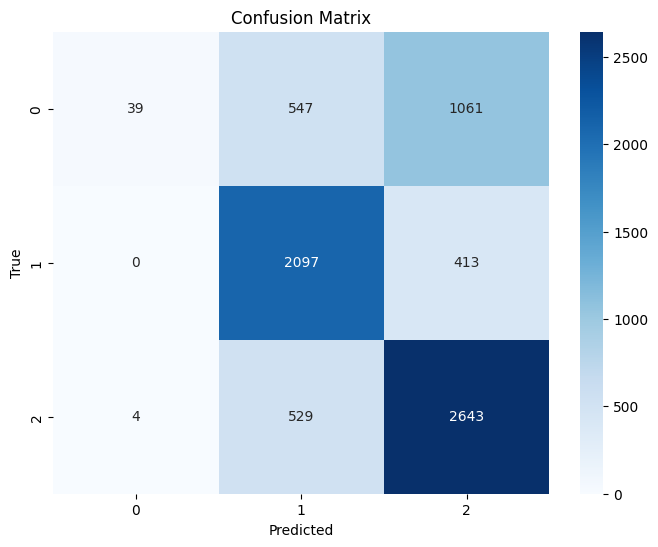

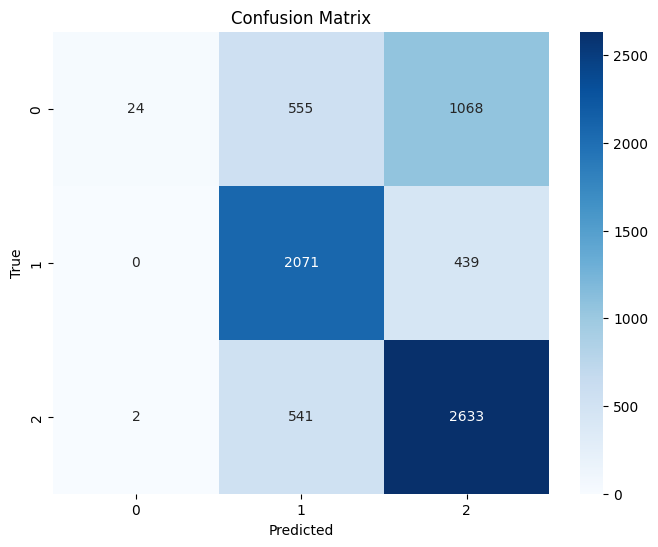

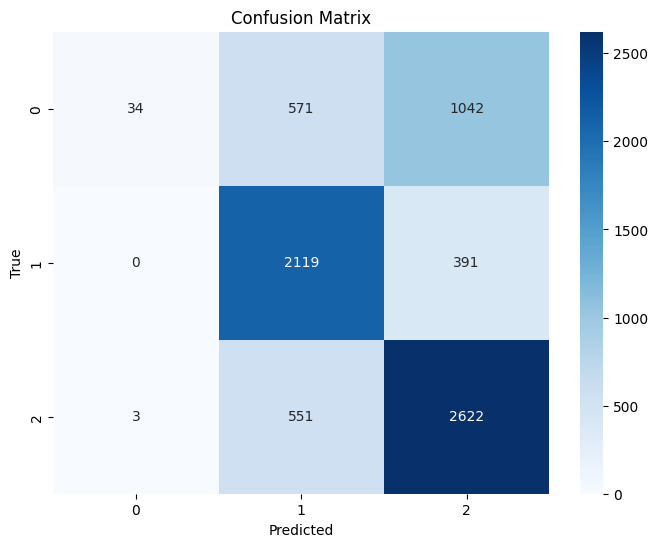

In [ ]:
for ngram in n_gram_range:
  run_experiment("BoW",ngram,max_features,"BoW")
  run_experiment("TFIDF",ngram,max_features,"TFIDF")